In [2]:
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
user_id = 582

In [4]:
def load_and_preprocess_data():
    # Load data
    movie_data = pd.read_csv('data/movies_grouplens/movies.dat',
                             delimiter='::', header=None, engine='python', encoding='latin1')
    rating_data = pd.read_csv('data/movies_grouplens/ratings.dat',
                              delimiter='::', header=None, engine='python', encoding='latin1')
    user_data = pd.read_csv('data/movies_grouplens/users.dat',
                            delimiter='::', header=None, engine='python', encoding='latin1')

    # Set column names
    movie_data.columns = ['MovieID', 'Title', 'Genres']
    rating_data.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
    user_data.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

    # Merge datasets
    df = pd.merge(rating_data, movie_data, on='MovieID', how='left')
    df = pd.merge(df, user_data, on='UserID', how='left')

    # Convert categorical variables
    df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})

    # Create index mappings
    users = df['UserID'].unique()
    movies = df['MovieID'].unique()

    user_to_idx = {user: idx for idx, user in enumerate(users)}
    movie_to_idx = {movie: idx for idx, movie in enumerate(movies)}

    # Add index columns
    df['User_idx'] = df['UserID'].map(user_to_idx)
    df['Movie_idx'] = df['MovieID'].map(movie_to_idx)

    # Normalize age and occupation values to start from 0
    df['Age'] = df['Age'] - df['Age'].min()
    df['Occupation'] = df['Occupation'] - df['Occupation'].min()

    return df, user_to_idx, movie_to_idx

In [5]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cuda') if torch.cuda.is_available() else device

In [6]:
ncf_cnn_model = torch.jit.load(
    'models/NCF_CNN_Enchanced.pt', map_location=device)

In [7]:
data, user_to_idx, movie_to_idx = load_and_preprocess_data()
idx_to_movie = {v: k for k, v in movie_to_idx.items()}
idx_to_user = {v: k for k, v in user_to_idx.items()}

In [8]:
def get_recommendations(user_id, model, data, user_to_idx, idx_to_movie, device, path='data/movies_grouplens/users.dat'):
    user_data = pd.read_csv(path,
                            delimiter='::', header=None, engine='python', encoding='latin1')

    user_data.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
    user_idx = user_to_idx[user_id]

    user_data['Gender'] = user_data['Gender'].map({'M': 0, 'F': 1})
    user_data['Age'] = user_data['Age'] - user_data['Age'].min()
    user_data['Occupation'] = user_data['Occupation'] - \
        user_data['Occupation'].min()

    ud = user_data[(user_data['UserID'] == user_id)].values
    not_watched = []
    list_ratings = []

    movie_idxs = np.arange(data['Movie_idx'].min(),
                           data['Movie_idx'].max()+1, 1)

    for movie in movie_idxs:
        if (not len(data[(data['User_idx'] == user_idx) & (data['Movie_idx'] == movie)]['Movie_idx'].to_list())):
            not_watched.append(movie)
        # else:
        #     print(f'Already Wacthed {movie}')

    for movie in not_watched:
        movie_features = ['Title', 'Genres']
        title, genres = data.iloc[data[data['Movie_idx']
                                       == movie].index[0]][movie_features]
        gender, age, occupation = ud[0][1:4]
        # print(gender, age, occupation)
        rating = model(torch.tensor([user_idx]).to(device), torch.tensor([movie]).to(device), torch.tensor(
            [gender]).to(device), torch.tensor([age]).to(device), torch.tensor([occupation]).to(device))

        list_ratings.append([user_id, idx_to_movie
                             [movie], title,
                            genres, gender, age, occupation, rating.item()])


# Define the column names
    column_names = ['UserID', 'MovieID', 'Title',
                    'Genres', 'Gender', 'Age', 'Occupation', 'Rating']

    # Create a DataFrame
    df_list = pd.DataFrame(list_ratings, columns=column_names)
    return df_list

In [9]:
cf_recommendations = get_recommendations(user_id, ncf_cnn_model, data,
                                         user_to_idx, idx_to_movie, device)

## CBF


In [10]:
from src.modules.CBF import CBF
cbf = CBF()

In [11]:
cbf_recommendations = cbf.cbf_recommend_movies(user_id)

## Hybrid

In [12]:
hybrid_recommendations = cf_recommendations.merge(
    cbf_recommendations, on=['MovieID', 'Title', 'Genres'])

In [13]:
hybrid_recommendations['Ensemble_Rating'] = 0.5 * \
    hybrid_recommendations['Rating'] + 0.5*hybrid_recommendations['Score']

In [14]:
hybrid_recommendations.sort_values(by='Ensemble_Rating', ascending=False)

,UserID,MovieID,Title,Genres,Gender,Age,Occupation,Rating,Score,Ensemble_Rating
469,582,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,0,17,4,4.639856,3.506560,4.073208
156,582,1968,"Breakfast Club, The (1985)",Comedy|Drama,0,17,4,4.526640,3.506560,4.016600
120,582,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0,17,4,4.820176,3.097833,3.959005
661,582,2431,Patch Adams (1998),Comedy|Drama,0,17,4,4.377867,3.506560,3.942214
2162,582,2861,For Love of the Game (1999),Comedy|Drama,0,17,4,4.350286,3.506560,3.928423
...,...,...,...,...,...,...,...,...,...,...
3513,582,3297,With Byrd at the South Pole (1930),Documentary,0,17,4,2.971081,0.000000,1.485541
3439,582,1145,Snowriders (1996),Documentary,0,17,4,2.966372,0.000000,1.483186
3602,582,134,Sonic Outlaws (1995),Documentary,0,17,4,2.966291,0.000000,1.483145
3415,582,3303,Black Tar Heroin: The Dark End of the Street (...,Documentary,0,17,4,2.961620,0.000000,1.480810


In [15]:
genres_list = list(data[(data['UserID'] == user_id) &
                   (data['Rating'] > 4)]['Genres'].values)

In [16]:
genres = [gen.split('|') for gen in genres_list]
genres = [i for gen in genres for i in gen]

In [17]:
from collections import Counter

In [18]:
counts = Counter(genres)

In [19]:
counts

Counter({'Drama': 17,
         'Comedy': 12,
         'Thriller': 11,
         'Action': 9,
         'Sci-Fi': 8,
         'Adventure': 4,
         'Animation': 2,
         "Children's": 2,
         'Horror': 2,
         'Romance': 2,
         'Crime': 2,
         'War': 2,
         'Film-Noir': 1,
         'Fantasy': 1,
         'Western': 1,
         'Musical': 1})

In [91]:
cbf = CBF()


def get_for_all_movies(ncf_cnn_model, cbf, data,
                       user_to_idx, idx_to_movie, device, path='data/movies_grouplens/users.dat'):

    user_data = pd.read_csv(path,
                            delimiter='::', header=None, engine='python', encoding='latin1')

    user_data.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

    user_data['Gender'] = user_data['Gender'].map({'M': 0, 'F': 1})
    user_data['Age'] = user_data['Age'] - user_data['Age'].min()
    user_data['Occupation'] = user_data['Occupation'] - \
        user_data['Occupation'].min()

    all_users = random.sample(range(1, 6041), 100)
    all_movies = list(
        range(data['Movie_idx'].min(), data['Movie_idx'].max() + 1))

    all_ratings = {}
    import time
    st = time.time()
    for user in all_users:
        user_idx = user_to_idx[user]
        ud = user_data[(user_data['UserID'] == user)].values
        gender, age, occupation = ud[0][1:4]
        cbf_recommendations = cbf.cbf_recommend_movies(user)
        list_ratings = []
        for movie in all_movies:
            movie_features = ['Title', 'Genres']
            title, genres = data.iloc[data[data['Movie_idx']
                                           == movie].index[0]][movie_features]
            rating = ncf_cnn_model(torch.tensor([user_idx]).to(device), torch.tensor([movie]).to(device), torch.tensor(
                [gender]).to(device), torch.tensor([age]).to(device), torch.tensor([occupation]).to(device))
            list_ratings.append([user, idx_to_movie
                                 [movie], title,
                                 genres, gender, age, occupation, rating.item()])
        column_names = ['UserID', 'MovieID', 'Title',
                        'Genres', 'Gender', 'Age', 'Occupation', 'Rating']

        cf_recommendations = pd.DataFrame(list_ratings, columns=column_names)
        hybrid_recommendations = cf_recommendations.merge(
            cbf_recommendations, on=['MovieID', 'Title', 'Genres'])
        hybrid_recommendations['Ensemble_Rating'] = 0.5 * \
            hybrid_recommendations['Rating'] + \
            0.5*hybrid_recommendations['Score']
        # hybrid_recommendations.sort_values(
        #     by='Ensemble_Rating', ascending=False)
        all_ratings[user] = hybrid_recommendations.sort_values(
            by='Ensemble_Rating', ascending=False)
        print((len(all_ratings.keys()) / 100)*100)
    return all_ratings

In [92]:
test_ratings = get_for_all_movies(ncf_cnn_model, cbf, data,
                                  user_to_idx, idx_to_movie, device)

1.0
2.0
3.0
4.0
5.0
6.0
7.000000000000001
8.0
9.0
10.0
11.0
12.0
13.0
14.000000000000002
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.000000000000004
28.999999999999996
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.00000000000001
56.00000000000001
56.99999999999999
57.99999999999999
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0


In [94]:
ud_rating = data[(data['Rating'] > 3) & (
    data['UserID'] == 3328)]['MovieID'].values
ud_rating

array([ 719, 3792, 2053, 1265,  590,  597, 1411, 2071, 1416, 2082, 1440,
       2247,  915, 2252, 1453,  780,  781, 1461, 2266, 2268, 2413, 1475,
       2289, 1487, 2433, 1493, 3252, 3255, 3258, 3259, 3408, 1667, 3271,
       3418, 1816, 1680, 2629, 1689, 1694, 3445,  230,  232,  249, 2668,
       2671, 1876, 2828, 2683, 2686, 2688,  271,  276,  425, 1896,  437,
        440, 3806, 3808, 3809, 3669,  454, 3812,  605,  608,  463,  471,
        628,  485, 3845, 1306,  492, 1171, 1183, 3871, 3873, 1190,  813,
       1358, 2302, 2303,  830, 1367,  840, 2324,  852, 1390, 1397, 2340,
       1554, 1704, 2369, 1569, 2510, 1711, 1721, 1722,  110, 2529, 2384,
       1584, 2396, 1597, 3343, 1758,  150,  151,  157,  300,  307,  308,
       2724, 1784,  318,  339,  195,  199, 2757, 1018,   21,   25, 1027,
        350,  356,   34,  357,   36, 3712, 2911, 1032,  360,  361,  508,
        509,   48, 1041,  371,  377,  378,  380,  527,  529,  532,  537,
        538,  539, 2012, 2015, 2953, 2023,   92, 37

In [82]:
relevant = 0
k = 15

for m in test_ratings[3328].head(k)['MovieID']:
    if m in ud_rating:
        relevant += 1

print(relevant/k)

0.13333333333333333


In [95]:
def calculate_precision_at_k(test_ratings, data, ks=[1, 5, 10, 15, 20, 25, 30, 40, 50]):
    precisions = []
    for user_id in test_ratings.keys():
        ud_rating = data[(data['Rating'] > 3) & (
            data['UserID'] == user_id)]['MovieID'].values
        prec = {}

        for k in ks:
            relevant = 0
            for m in test_ratings[user_id].head(k)['MovieID']:
                if m in ud_rating:
                    relevant += 1

            prec[k] = (relevant/k)

        precisions.append(prec)

    return precisions

In [96]:
precisions = calculate_precision_at_k(test_ratings, data)

In [97]:
ks = [1, 5, 10, 15, 20, 25, 30, 40, 50]
avg_prec = {}
n = len(test_ratings.keys())
for k in ks:
    total = 0
    for e in precisions:
        total += e[k]
    avg_prec[k] = total/n

In [98]:
avg_prec

{1: 0.41,
 5: 0.33399999999999985,
 10: 0.32500000000000007,
 15: 0.29399999999999976,
 20: 0.27399999999999997,
 25: 0.25559999999999994,
 30: 0.24466666666666653,
 40: 0.22275000000000006,
 50: 0.20439999999999992}

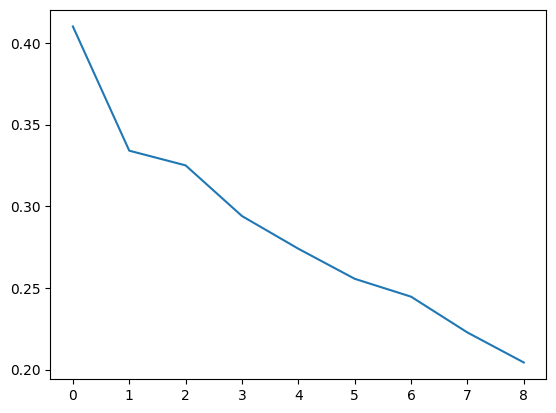

In [99]:
plt.plot(avg_prec.values())